<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/ML_model_forescasting_ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/datadigger01/AI-Trade/main/Data/coffee_future_price.csv"
response = requests.get(url)

# Save the content to a temporary file
with open("price_data.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file into a pandas DataFrame, skipping the first two rows
df = pd.read_csv("price_data.csv")

# Display the first few rows of the DataFrame
display(df.head())

,Date,Close_Price,High_Price,Low,Open,Volume
0,2020-11-05,105.949997,106.800003,103.550003,103.900002,29467
1,2020-11-06,106.949997,108.000000,105.949997,106.550003,18754
2,2020-11-09,106.849998,109.349998,106.349998,107.349998,26289
3,2020-11-10,107.300003,107.650002,105.349998,106.750000,28673
4,2020-11-11,109.099998,110.550003,107.800003,108.000000,25497


#### Feature(예측에 사용되는 변수들) 생성

In [24]:
"""
커피 가격 예측을 위한 Feature Engineering 함수 모듈

사용 예시:
    df = pd.read_csv('price_data.csv')
    df_with_features = create_all_features(df)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def create_lag_features(df, price_cols=['Close_Price', 'Open', 'High_Price', 'Low'],
                       close_lags=[1, 2, 3, 5, 7, 14, 21, 30],
                       other_lags=[1, 2, 3, 5]):
    """
    과거 가격 정보 Lag Features 생성

    Args:
        df: 원본 데이터프레임
        price_cols: lag를 생성할 컬럼들
        close_lags: Close Price에 대한 lag 기간
        other_lags: 다른 가격들에 대한 lag 기간

    Returns:
        lag feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Close Price Lags
    for lag in close_lags:
        df[f'close_lag_{lag}'] = df['Close_Price'].shift(lag)

    # Open, High, Low Lags
    for lag in other_lags:
        df[f'open_lag_{lag}'] = df['Open'].shift(lag)
        df[f'high_lag_{lag}'] = df['High_Price'].shift(lag)
        df[f'low_lag_{lag}'] = df['Low'].shift(lag)

    return df


def create_return_features(df, periods=[2, 3, 5, 7, 14]):
    """
    가격 변화율 및 수익률 Features 생성

    Args:
        df: 원본 데이터프레임
        periods: 수익률 계산 기간

    Returns:
        return feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Daily Returns
    df['daily_return'] = df['Close_Price'].pct_change(1)
    df['daily_return_lag1'] = df['daily_return'].shift(1)

    # Multi-period Returns
    for period in periods:
        df[f'return_{period}d'] = df['Close_Price'].pct_change(period).shift(1)

    # Price Changes
    df['price_change_1d'] = (df['Close_Price'] - df['Close_Price'].shift(1)).shift(1)
    df['price_change_5d'] = (df['Close_Price'] - df['Close_Price'].shift(5)).shift(1)

    return df


def create_moving_average_features(df, sma_windows=[5, 10, 20, 50, 100],
                                   ema_windows=[5, 10, 20]):
    """
    이동평균 Features 생성

    Args:
        df: 원본 데이터프레임
        sma_windows: 단순이동평균 윈도우 크기
        ema_windows: 지수이동평균 윈도우 크기

    Returns:
        이동평균 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Simple Moving Averages
    for window in sma_windows:
        df[f'sma_{window}'] = df['Close_Price'].rolling(window=window).mean().shift(1)

    # Exponential Moving Averages
    for window in ema_windows:
        df[f'ema_{window}'] = df['Close_Price'].ewm(span=window, adjust=False).mean().shift(1)

    # MA Crossover Features
    df['sma_5_10_diff'] = (df['sma_5'] - df['sma_10'])
    df['sma_10_20_diff'] = (df['sma_10'] - df['sma_20'])
    df['sma_20_50_diff'] = (df['sma_20'] - df['sma_50'])

    # Price relative to MAs
    df['price_to_sma_5'] = (df['Close_Price'] / df['sma_5'].shift(-1)) - 1
    df['price_to_sma_20'] = (df['Close_Price'] / df['sma_20'].shift(-1)) - 1
    df['price_to_sma_50'] = (df['Close_Price'] / df['sma_50'].shift(-1)) - 1

    return df


def create_volatility_features(df, windows=[5, 10, 20], atr_period=14):
    """
    변동성 Features 생성

    Args:
        df: 원본 데이터프레임
        windows: 변동성 계산 윈도우
        atr_period: ATR 계산 기간

    Returns:
        변동성 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Standard Deviation
    daily_return = df['Close_Price'].pct_change(1)
    for window in windows:
        df[f'volatility_{window}d'] = daily_return.rolling(window=window).std().shift(1)

    # High-Low Range
    df['hl_range'] = ((df['High_Price'] - df['Low']) / df['Low']).shift(1)
    df['hl_range_5d_avg'] = df['hl_range'].shift(-1).rolling(window=5).mean().shift(1)

    # ATR (Average True Range)
    df['tr'] = df[['High_Price', 'Close_Price']].max(axis=1) - df[['Low', 'Close_Price']].min(axis=1)
    df['atr_14'] = df['tr'].rolling(window=atr_period).mean().shift(1)

    return df


def create_momentum_features(df, rsi_periods=[7, 14]):
    """
    모멘텀 지표 Features 생성 (RSI, MACD)

    Args:
        df: 원본 데이터프레임
        rsi_periods: RSI 계산 기간

    Returns:
        모멘텀 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    for period in rsi_periods:
        df[f'rsi_{period}'] = calculate_rsi(df['Close_Price'], period).shift(1)

    # MACD
    ema_12 = df['Close_Price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close_Price'].ewm(span=26, adjust=False).mean()
    df['macd'] = (ema_12 - ema_26).shift(1)
    df['macd_signal'] = df['macd'].shift(-1).ewm(span=9, adjust=False).mean().shift(1)
    df['macd_histogram'] = (df['macd'] - df['macd_signal'])

    # Momentum
    df['momentum_5'] = (df['Close_Price'] / df['Close_Price'].shift(5) - 1).shift(1)
    df['momentum_10'] = (df['Close_Price'] / df['Close_Price'].shift(10) - 1).shift(1)

    return df


def create_bollinger_bands(df, window=20, num_std=2):
    """
    볼린저 밴드 Features 생성

    Args:
        df: 원본 데이터프레임
        window: 이동평균 윈도우
        num_std: 표준편차 배수

    Returns:
        볼린저 밴드 feature가 추가된 데이터프레임
    """
    df = df.copy()

    sma_20 = df['Close_Price'].rolling(window=window).mean()
    std_20 = df['Close_Price'].rolling(window=window).std()

    df['bb_upper'] = (sma_20 + (std_20 * num_std)).shift(1)
    df['bb_middle'] = sma_20.shift(1)
    df['bb_lower'] = (sma_20 - (std_20 * num_std)).shift(1)
    df['bb_width'] = ((df['bb_upper'] - df['bb_lower']) / df['bb_middle'])
    df['bb_position'] = ((df['Close_Price'] - df['bb_lower'].shift(-1)) /
                          (df['bb_upper'].shift(-1) - df['bb_lower'].shift(-1)))

    return df


def create_volume_features(df, volume_lags=[1, 2, 3, 5], sma_windows=[5, 20]):
    """
    거래량 Features 생성

    Args:
        df: 원본 데이터프레임
        volume_lags: 거래량 lag 기간
        sma_windows: 거래량 이동평균 윈도우

    Returns:
        거래량 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Volume Lags
    for lag in volume_lags:
        df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)

    # Volume Moving Averages
    for window in sma_windows:
        df[f'volume_sma_{window}'] = df['Volume'].rolling(window=window).mean().shift(1)

    # Volume Ratio
    df['volume_ratio'] = (df['Volume'] / df['volume_sma_20'].shift(-1)).shift(1)

    # Price-Volume Trend
    df['price_volume_trend'] = ((df['Close_Price'] - df['Close_Price'].shift(1)) /
                                 df['Close_Price'].shift(1) * df['Volume']).shift(1)

    return df


def create_price_pattern_features(df):
    """
    가격 패턴 Features 생성

    Args:
        df: 원본 데이터프레임

    Returns:
        가격 패턴 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Intraday Range
    df['intraday_range'] = ((df['High_Price'] - df['Low']) / df['Open']).shift(1)

    # Open-Close Relationship
    df['open_close_diff'] = ((df['Close_Price'] - df['Open']) / df['Open']).shift(1)
    df['is_bullish'] = (df['Close_Price'] > df['Open']).astype(int).shift(1)

    # Gap
    df['gap'] = ((df['Open'] - df['Close_Price'].shift(1)) / df['Close_Price'].shift(1)).shift(1)

    # High/Low relative to Close
    df['high_to_close'] = ((df['High_Price'] - df['Close_Price']) / df['Close_Price']).shift(1)
    df['low_to_close'] = ((df['Close_Price'] - df['Low']) / df['Close_Price']).shift(1)

    return df


def create_time_features(df):
    """
    시간 기반 Features 생성

    Args:
        df: 원본 데이터프레임 (Date 컬럼 필수)

    Returns:
        시간 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 기본 시간 특성
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df


def create_statistical_features(df, window=20):
    """
    통계적 Features 생성

    Args:
        df: 원본 데이터프레임
        window: rolling 윈도우 크기

    Returns:
        통계 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Min/Max
    df['rolling_max_20'] = df['Close_Price'].rolling(window=window).max().shift(1)
    df['rolling_min_20'] = df['Close_Price'].rolling(window=window).min().shift(1)
    df['distance_from_max_20'] = ((df['rolling_max_20'] - df['Close_Price']) /
                                    df['rolling_max_20']).shift(-1)
    df['distance_from_min_20'] = ((df['Close_Price'] - df['rolling_min_20']) /
                                    df['rolling_min_20']).shift(-1)

    # Percentile Rank
    df['percentile_rank_20'] = df['Close_Price'].rolling(window=window).apply(
        lambda x: pd.Series(x).rank().iloc[-1] / len(x), raw=False
    ).shift(1)

    return df


def create_all_features(df, include_target=True, remove_nan=True):
    """
    모든 Feature를 한번에 생성하는 메인 함수

    Args:
        df: 원본 데이터프레임 (Date, Close_Price, High_Price, Low, Open, Volume 컬럼 필수)
        include_target: 타겟 변수 (다음날 종가) 포함 여부
        remove_nan: 결측치 제거 여부 (기본값: True)

    Returns:
        모든 feature가 추가된 데이터프레임

    Example:
        >>> df = pd.read_csv('price_data.csv')
        >>> df['Date'] = pd.to_datetime(df['Date'])
        >>> df = df.sort_values('Date').reset_index(drop=True)
        >>> df_with_features = create_all_features(df, remove_nan=True)
    """
    df = df.copy()

    # 날짜 정렬 확인
    if not df['Date'].is_monotonic_increasing:
        df = df.sort_values('Date').reset_index(drop=True)

    # 타겟 변수 생성
    if include_target:
        df['target_next_close'] = df['Close_Price'].shift(-1)

    print("Feature Engineering 시작...")

    # 1. Lag Features
    print("  [1/10] Lag Features 생성 중...")
    df = create_lag_features(df)

    # 2. Return Features
    print("  [2/10] Return Features 생성 중...")
    df = create_return_features(df)

    # 3. Moving Average Features
    print("  [3/10] Moving Average Features 생성 중...")
    df = create_moving_average_features(df)

    # 4. Volatility Features
    print("  [4/10] Volatility Features 생성 중...")
    df = create_volatility_features(df)

    # 5. Momentum Features
    print("  [5/10] Momentum Features 생성 중...")
    df = create_momentum_features(df)

    # 6. Bollinger Bands
    print("  [6/10] Bollinger Bands 생성 중...")
    df = create_bollinger_bands(df)

    # 7. Volume Features
    print("  [7/10] Volume Features 생성 중...")
    df = create_volume_features(df)

    # 8. Price Pattern Features
    print("  [8/10] Price Pattern Features 생성 중...")
    df = create_price_pattern_features(df)

    # 9. Time Features
    print("  [9/10] Time Features 생성 중...")
    df = create_time_features(df)

    # 10. Statistical Features
    print("  [10/10] Statistical Features 생성 중...")
    df = create_statistical_features(df)

    print("✅ Feature Engineering 완료!")

    # Feature 개수 출력
    original_cols = ['Date', 'Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    target_col = ['target_next_close'] if include_target else []
    feature_cols = [col for col in df.columns
                   if col not in original_cols and col not in target_col]

    print(f"\n생성된 Feature 수: {len(feature_cols)}")
    print(f"결측치 제거 전 데이터 크기: {len(df)}행")

    # 결측치 제거
    if remove_nan:
        nan_count_before = df.isnull().any(axis=1).sum()
        df = df.dropna().reset_index(drop=True)
        print(f"결측치가 있는 행 수: {nan_count_before}행")
        print(f"결측치 제거 후 데이터 크기: {len(df)}행 ✅")
    else:
        nan_count = df.isnull().any(axis=1).sum()
        print(f"결측치가 있는 행 수: {nan_count}행 (제거하지 않음)")

    return df


# 사용 예시
if __name__ == "__main__":
    # 데이터 로드
    # df = pd.read_csv('price_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])

    # Feature Engineering (결측치 자동 제거)
    df_with_features = create_all_features(df, include_target=True, remove_nan=True)

    # 저장
    #output_path = '/content/drive/MyDrive/AI와무역투자론/Data/coffee_features_clean.csv'
    #df_with_features.to_csv(output_path, index=False)
    #print(f"\n💾 저장 완료: {output_path}")

    # 샘플 데이터 확인
    print("\n📊 샘플 데이터 (처음 5행):")
    print(df_with_features.head())

Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Return Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Bollinger Bands 생성 중...
  [7/10] Volume Features 생성 중...
  [8/10] Price Pattern Features 생성 중...
  [9/10] Time Features 생성 중...
  [10/10] Statistical Features 생성 중...
✅ Feature Engineering 완료!

생성된 Feature 수: 90
결측치 제거 전 데이터 크기: 1158행
결측치가 있는 행 수: 101행
결측치 제거 후 데이터 크기: 1057행 ✅

💾 저장 완료: /content/drive/MyDrive/AI와무역투자론/Data/coffee_features_clean.csv

📊 샘플 데이터 (처음 5행):
        Date  Close_Price  High_Price         Low        Open  Volume  \
0 2021-08-24   183.300003  184.250000  180.199997  180.199997      41   
1 2021-08-25   184.050003  185.350006  183.899994  185.350006      40   
2 2021-08-26   185.649994  184.899994  184.000000  184.000000      14   
3 2021-08-27   189.500000  189.600006  186.050003  186.050003      20   
4 2021-08-30   197.399994  196.500000  190.550

### RandomForest 결과 시각화

In [ ]:

# 사용 예시:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df_target=df_with_features.copy()

# Feature와 Target 분리
X = df_target.drop(['Date', 'target_next_close'], axis=1)
y = df_target['target_next_close']

# Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)


# 모델 학습 후
model = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=42)
model.fit(X, y)

# 대상 트리 추출
target_tree = model.estimators_[0]

# Define feature_cols from the feature matrix X
feature_cols = X.columns.tolist()

# 시각화
plt.figure(figsize=(25, 20))
plot_tree(
    target_tree,
    feature_names=feature_cols,  # Feature 이름 리스트
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4  # 깊이 제한
)
plt.title('Target Tree', fontsize=16)
#plt.savefig('my_tree.png', dpi=300, bbox_inches='tight')
plt.show()

## RandomForest 예측모델 생성 및 성능평가

Random Forest 시계열 예측 모델 학습 시작

[1단계] 데이터 로드 및 기본 탐색
--------------------------------------------------------------------------------
데이터 shape: (1158, 97)

결측치 개수:
0 개

데이터 타입:
float64           90
int32              4
datetime64[ns]     1
int64              1
UInt32             1
Name: count, dtype: int64

[2단계] 시계열 특성 파악
--------------------------------------------------------------------------------
날짜 범위: 2021-04-01 00:00:00 ~ 2025-11-04 00:00:00
총 1158일 데이터

Close_Price 통계:
  - 평균: 232.09
  - 표준편차: 73.74
  - 최소값: 121.60
  - 최대값: 438.90

[3단계] Feature 선택 및 전처리
--------------------------------------------------------------------------------
제외할 컬럼: ['Date', 'target_next_close']

Feature 개수: 95
Target 개수: 1158

Feature 목록:
  1. Close_Price
  2. High_Price
  3. Low
  4. Open
  5. Volume
  6. close_lag_1
  7. close_lag_2
  8. close_lag_3
  9. close_lag_5
  10. close_lag_7
  11. close_lag_14
  12. close_lag_21
  13. close_lag_30
  14. open_lag_1
  15. high_lag_1
  16. low_lag_1
  17. op

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.8s


✓ 학습 완료!

[7단계] 예측 수행
--------------------------------------------------------------------------------
✓ 예측 완료!

[8단계] 모델 평가
--------------------------------------------------------------------------------
📊 Train Set 성능:
  - RMSE: 1.6832
  - MAE: 1.1777
  - MAPE: 0.5312%
  - R² Score: 0.9993

📊 Test Set 성능:
  - RMSE: 17.5537
  - MAE: 13.9830
  - MAPE: 4.2896%
  - R² Score: 0.8204

[9단계] Feature Importance 분석
--------------------------------------------------------------------------------

상위 20개 중요 Feature:
       feature  importance
   Close_Price    0.232779
       sma_100    0.171276
           Low    0.119946
    High_Price    0.043784
     low_lag_1    0.037662
    high_lag_1    0.036784
    open_lag_1    0.036557
          Open    0.034911
   close_lag_1    0.029846
   close_lag_2    0.029351
        sma_50    0.029161
    open_lag_2    0.028954
   close_lag_3    0.021426
rolling_max_20    0.021385
        ema_20    0.015113
         ema_5    0.015028
         sma_5    0.014794


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



✓ 튜닝 완료!

최적 파라미터:
  - n_estimators: 100
  - min_samples_split: 3
  - min_samples_leaf: 1
  - max_features: None
  - max_depth: 20

📊 튜닝 후 Test Set 성능:
  - RMSE: 17.5360 (개선: 0.0177)
  - MAE: 13.9518 (개선: 0.0312)
  - MAPE: 4.2794% (개선: 0.0102%)
  - R² Score: 0.8208 (개선: 0.0004)

[11단계] 시계열 교차 검증 (TimeSeriesSplit)
--------------------------------------------------------------------------------
3-Fold 시계열 교차 검증 수행 중...
  Fold 1 - RMSE: 7.6104
  Fold 2 - RMSE: 3.8867
  Fold 3 - RMSE: 86.8017

평균 CV RMSE: 32.7663 (±38.2390)

[12단계] 결과 시각화
--------------------------------------------------------------------------------

[13단계] 모델 저장
--------------------------------------------------------------------------------

[최종] 결과 요약 저장
--------------------------------------------------------------------------------

✅ 모든 프로세스 완료!

생성된 파일:
  1. rf_model_basic.pkl - 기본 Random Forest 모델
  2. rf_model_tuned.pkl - 튜닝된 Random Forest 모델
  3. feature_importance.csv - Feature 중요도 순위
  4. model_summary.csv -

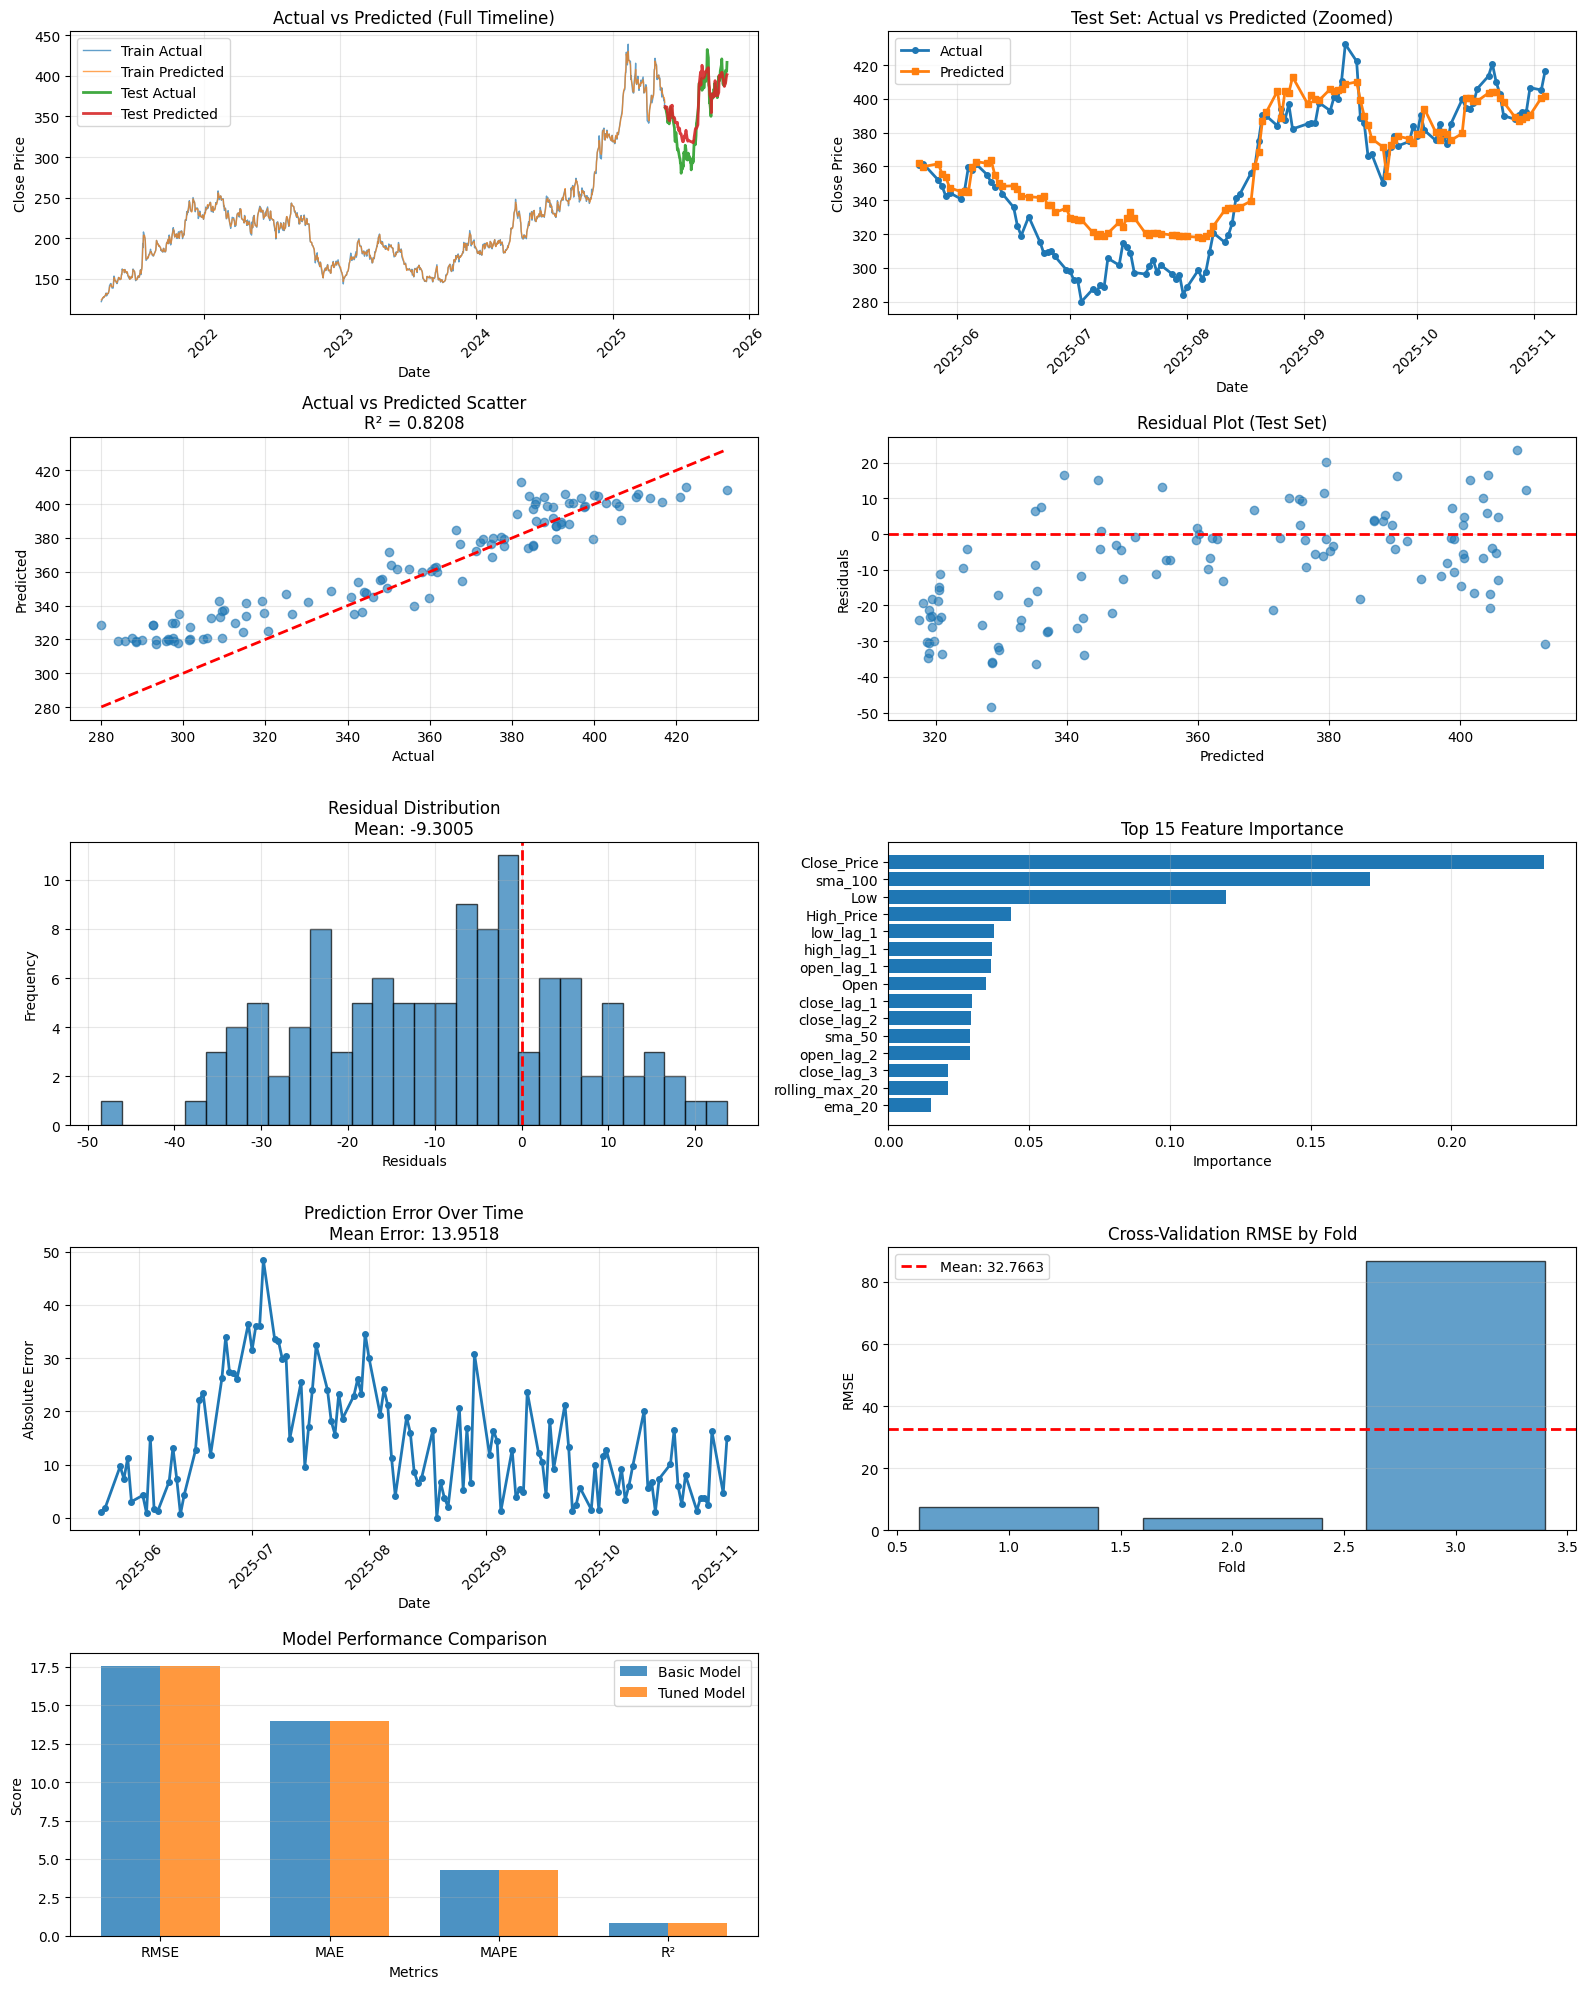

In [ ]:
"""
Random Forest 시계열 예측 모델
Close_Price 예측을 위한 전체 프로세스
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("Random Forest 시계열 예측 모델 학습 시작")
print("=" * 80)

# ============================================================================
# 1. 데이터 로드 및 기본 탐색
# ============================================================================
print("\n[1단계] 데이터 로드 및 기본 탐색")
print("-" * 80)

# 데이터 로드
#df_target = pd.read_csv('/content/coffee_features_clean.csv')

print(f"데이터 shape: {df_target.shape}")
print(f"\n결측치 개수:\n{df_target.isnull().sum().sum()} 개")
print(f"\n데이터 타입:\n{df_target.dtypes.value_counts()}")
#print(f"\n기본 통계량:")
#print(df[['Close_Price', 'High_Price', 'Low', 'Volume']].describe())

# ============================================================================
# 2. 시계열 특성 파악
# ============================================================================
print("\n[2단계] 시계열 특성 파악")
print("-" * 80)

# Date를 datetime으로 변환
df['Date'] = pd.to_datetime(df_target['Date'])
print(f"날짜 범위: {df_target['Date'].min()} ~ {df_target['Date'].max()}")
print(f"총 {len(df_target)}일 데이터")

# Target 변수 기본 통계
print(f"\nClose_Price 통계:")
print(f"  - 평균: {df_target['Close_Price'].mean():.2f}")
print(f"  - 표준편차: {df_target['Close_Price'].std():.2f}")
print(f"  - 최소값: {df_target['Close_Price'].min():.2f}")
print(f"  - 최대값: {df_target['Close_Price'].max():.2f}")

# ============================================================================
# 3. Feature 선택 및 전처리
# ============================================================================
print("\n[3단계] Feature 선택 및 전처리")
print("-" * 80)

# 제외할 컬럼 정의
columns_to_drop = ['Date', 'target_next_close']
print(f"제외할 컬럼: {columns_to_drop}")

# Feature와 Target 분리
#df_target = df.copy()
X = df_target.drop(columns_to_drop, axis=1)
y = df_target['target_next_close']

print(f"\nFeature 개수: {X.shape[1]}")
print(f"Target 개수: {len(y)}")
print(f"\nFeature 목록:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# 4. 데이터 분할 (시계열 순서 유지)
# ============================================================================
print("\n[4단계] 데이터 분할 (Train/Test)")
print("-" * 80)

# Train/Test 분할 (shuffle=False로 시계열 순서 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Train 기간: {df_target.iloc[y_train.index[0]]['Date']} ~ {df_target.iloc[y_train.index[-1]]['Date']}")
print(f"Test 기간: {df_target.iloc[y_test.index[0]]['Date']} ~ {df_target.iloc[y_test.index[-1]]['Date']}")

# ============================================================================
# 6. 모델 학습 (기본 모델)
# ============================================================================
print("\n[6단계] 기본 Random Forest 모델 학습")
print("-" * 80)

# 기본 Random Forest 모델
rf_basic = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("모델 학습 중...")
rf_basic.fit(X_train, y_train)
print("✓ 학습 완료!")

# ============================================================================
# 7. 예측 수행
# ============================================================================
print("\n[7단계] 예측 수행")
print("-" * 80)

# Train과 Test 예측
y_train_pred = rf_basic.predict(X_train)
y_test_pred = rf_basic.predict(X_test)

print("✓ 예측 완료!")

# ============================================================================
# 8. 모델 평가
# ============================================================================
print("\n[8단계] 모델 평가")
print("-" * 80)

def calculate_mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# Train 성능
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = calculate_mape(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test 성능
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = calculate_mape(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("📊 Train Set 성능:")
print(f"  - RMSE: {train_rmse:.4f}")
print(f"  - MAE: {train_mae:.4f}")
print(f"  - MAPE: {train_mape:.4f}%")
print(f"  - R² Score: {train_r2:.4f}")

print("\n📊 Test Set 성능:")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - MAPE: {test_mape:.4f}%")
print(f"  - R² Score: {test_r2:.4f}")

# ============================================================================
# 9. Feature Importance 분석
# ============================================================================
print("\n[9단계] Feature Importance 분석")
print("-" * 80)

# Feature Importance 계산
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_basic.feature_importances_
}).sort_values('importance', ascending=False)

print("\n상위 20개 중요 Feature:")
print(feature_importance.head(20).to_string(index=False))

# Feature Importance 저장
feature_importance.to_csv('/content/feature_importance.csv', index=False)
print("\n✓ Feature importance를 'feature_importance.csv'에 저장했습니다.")

# ============================================================================
# 10. 하이퍼파라미터 튜닝
# ============================================================================
print("\n[10단계] 하이퍼파라미터 튜닝 (RandomizedSearchCV)")
print("-" * 80)

# 파라미터 그리드 정의
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("RandomizedSearchCV 실행 중... (시간이 걸릴 수 있습니다)")
print(f"파라미터 조합 수: {len(param_distributions['n_estimators']) * len(param_distributions['max_depth']) * len(param_distributions['min_samples_split']) * len(param_distributions['min_samples_leaf']) * len(param_distributions['max_features'])} 중 20개 랜덤 샘플링")

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=20,  # 20개 조합만 테스트
    #cv=3,  # 3-fold cross validation
    cv=TimeSeriesSplit(n_splits=3),  # 3-fold cross validation

    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print("\n✓ 튜닝 완료!")
print(f"\n최적 파라미터:")
for param, value in rf_random.best_params_.items():
    print(f"  - {param}: {value}")

# 최적 모델로 예측
y_train_pred_tuned = rf_random.predict(X_train)
y_test_pred_tuned = rf_random.predict(X_test)

# 튜닝 후 성능
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
test_mape_tuned = calculate_mape(y_test, y_test_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

print("\n📊 튜닝 후 Test Set 성능:")
print(f"  - RMSE: {test_rmse_tuned:.4f} (개선: {test_rmse - test_rmse_tuned:.4f})")
print(f"  - MAE: {test_mae_tuned:.4f} (개선: {test_mae - test_mae_tuned:.4f})")
print(f"  - MAPE: {test_mape_tuned:.4f}% (개선: {test_mape - test_mape_tuned:.4f}%)")
print(f"  - R² Score: {test_r2_tuned:.4f} (개선: {test_r2_tuned - test_r2:.4f})")

# ============================================================================
# 11. 시계열 교차 검증
# ============================================================================
print("\n[11단계] 시계열 교차 검증 (TimeSeriesSplit)")
print("-" * 80)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []

print("3-Fold 시계열 교차 검증 수행 중...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 최적 모델로 학습
    cv_model = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
    cv_model.fit(X_cv_train, y_cv_train)

    # 검증 세트 예측
    y_cv_pred = cv_model.predict(X_cv_val)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_scores.append(cv_rmse)

    print(f"  Fold {fold} - RMSE: {cv_rmse:.4f}")

print(f"\n평균 CV RMSE: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# ============================================================================
# 12. 결과 시각화
# ============================================================================
print("\n[12단계] 결과 시각화")
print("-" * 80)

# 그림 크기 설정
fig = plt.figure(figsize=(16, 20)) # Adjust figure size for 2 columns

# 1) 실제값 vs 예측값 비교 (Train + Test)
ax1 = plt.subplot(5, 2, 1) # 5 rows, 2 columns, position 1
dates_train = df_target.iloc[y_train.index]['Date']
dates_test = df_target.iloc[y_test.index]['Date']

plt.plot(dates_train, y_train.values, label='Train Actual', alpha=0.7, linewidth=1)
plt.plot(dates_train, y_train_pred_tuned, label='Train Predicted', alpha=0.7, linewidth=1)
plt.plot(dates_test, y_test.values, label='Test Actual', alpha=0.9, linewidth=2)
plt.plot(dates_test, y_test_pred_tuned, label='Test Predicted', alpha=0.9, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted (Full Timeline)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2) Test 구간만 확대
ax2 = plt.subplot(5, 2, 2) # 5 rows, 2 columns, position 2
plt.plot(dates_test, y_test.values, 'o-', label='Actual', linewidth=2, markersize=4)
plt.plot(dates_test, y_test_pred_tuned, 's-', label='Predicted', linewidth=2, markersize=4)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test Set: Actual vs Predicted (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3) Scatter Plot (Test Set)
ax3 = plt.subplot(5, 2, 3) # 5 rows, 2 columns, position 3
plt.scatter(y_test, y_test_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Scatter\nR² = {test_r2_tuned:.4f}')
plt.grid(True, alpha=0.3)

# 4) 잔차 분석 (Test Set)
ax4 = plt.subplot(5, 2, 4) # 5 rows, 2 columns, position 4
residuals = y_test - y_test_pred_tuned
plt.scatter(y_test_pred_tuned, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)

# 5) 잔차 분포
ax5 = plt.subplot(5, 2, 5) # 5 rows, 2 columns, position 5
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution\nMean: {residuals.mean():.4f}')
plt.grid(True, alpha=0.3)

# 6) Feature Importance (상위 15개)
ax6 = plt.subplot(5, 2, 6) # 5 rows, 2 columns, position 6
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# 7) 예측 오차 시계열 (Test Set)
ax7 = plt.subplot(5, 2, 7) # 5 rows, 2 columns, position 7
errors = np.abs(y_test - y_test_pred_tuned)
plt.plot(dates_test, errors, 'o-', linewidth=2, markersize=4)
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.title(f'Prediction Error Over Time\nMean Error: {errors.mean():.4f}')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8) 교차 검증 결과
ax8 = plt.subplot(5, 2, 8) # 5 rows, 2 columns, position 8
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, edgecolor='black') # Modified range
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cv_scores):.4f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE by Fold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 9) 성능 비교 (기본 모델 vs 튜닝 모델)
ax9 = plt.subplot(5, 2, 9) # 5 rows, 2 columns, position 9
metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
basic_scores = [test_rmse, test_mae, test_mape, test_r2]
tuned_scores = [test_rmse_tuned, test_mae_tuned, test_mape_tuned, test_r2_tuned]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, basic_scores, width, label='Basic Model', alpha=0.8)
plt.bar(x + width/2, tuned_scores, width, label='Tuned Model', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


# Add a placeholder for the 10th plot if needed, or adjust the layout
# ax10 = plt.subplot(5, 2, 10) # 5 rows, 2 columns, position 10
# plt.axis('off') # Turn off the axis for the empty plot

plt.tight_layout()
#plt.savefig('/content/rf_model_results.png', dpi=300, bbox_inches='tight')
#print("✓ 시각화 결과를 'rf_model_results.png'에 저장했습니다.")

# ============================================================================
# 13. 모델 저장
# ============================================================================
print("\n[13단계] 모델 저장")
print("-" * 80)

# 최적 모델 저장
#joblib.dump(rf_random.best_estimator_, '/content/rf_model_tuned.pkl')
#print("✓ 튜닝된 모델을 'rf_model_tuned.pkl'에 저장했습니다.")

# 기본 모델도 저장
#joblib.dump(rf_basic, '/content/rf_model_basic.pkl')
#print("✓ 기본 모델을 'rf_model_basic.pkl'에 저장했습니다.")

# ============================================================================
# 결과 요약 저장
# ============================================================================
print("\n[최종] 결과 요약 저장")
print("-" * 80)

summary = {
    'model': ['Basic RF', 'Tuned RF'],
    'test_rmse': [test_rmse, test_rmse_tuned],
    'test_mae': [test_mae, test_mae_tuned],
    'test_mape': [test_mape, test_mape_tuned],
    'test_r2': [test_r2, test_r2_tuned],
    'train_rmse': [train_rmse, np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))],
    'cv_mean_rmse': [None, np.mean(cv_scores)],
    'cv_std_rmse': [None, np.std(cv_scores)]
}

summary_df = pd.DataFrame(summary)
#summary_df.to_csv('/mnt/user-data/outputs/model_summary.csv', index=False)
#print("✓ 모델 성능 요약을 'model_summary.csv'에 저장했습니다.")

print("\n" + "=" * 80)
print("✅ 모든 프로세스 완료!")
print("=" * 80)
print("\n생성된 파일:")
print("  1. rf_model_basic.pkl - 기본 Random Forest 모델")
print("  2. rf_model_tuned.pkl - 튜닝된 Random Forest 모델")
print("  3. feature_importance.csv - Feature 중요도 순위")
print("  4. model_summary.csv - 모델 성능 요약")
print("  5. rf_model_results.png - 결과 시각화 차트")
print("\n최종 Test Set 성능 (튜닝 모델):")
print(f"  - RMSE: {test_rmse_tuned:.4f}")
print(f"  - MAE: {test_mae_tuned:.4f}")
print(f"  - MAPE: {test_mape_tuned:.4f}%")
print(f"  - R² Score: {test_r2_tuned:.4f}")
print("=" * 80)

### XGboost(GBM) 예측 모델 및 성능평가

XGBoost 시계열 예측 모델 학습 시작

[1단계] 데이터 로드 및 기본 탐색
--------------------------------------------------------------------------------
데이터 shape: (1158, 97)

결측치 개수:
0 개

데이터 타입:
float64           90
int32              4
datetime64[ns]     1
int64              1
UInt32             1
Name: count, dtype: int64

[2단계] 시계열 특성 파악
--------------------------------------------------------------------------------
날짜 범위: 2021-04-01 00:00:00 ~ 2025-11-04 00:00:00
총 1158일 데이터

Close_Price 통계:
  - 평균: 232.09
  - 표준편차: 73.74
  - 최소값: 121.60
  - 최대값: 438.90

[3단계] Feature 선택 및 전처리
--------------------------------------------------------------------------------
제외할 컬럼: ['Date', 'target_next_close']

Feature 개수: 95
Target 개수: 1158

Feature 목록:
  1. Close_Price
  2. High_Price
  3. Low
  4. Open
  5. Volume
  6. close_lag_1
  7. close_lag_2
  8. close_lag_3
  9. close_lag_5
  10. close_lag_7
  11. close_lag_14
  12. close_lag_21
  13. close_lag_30
  14. open_lag_1
  15. high_lag_1
  16. low_lag_1
  17. open_lag

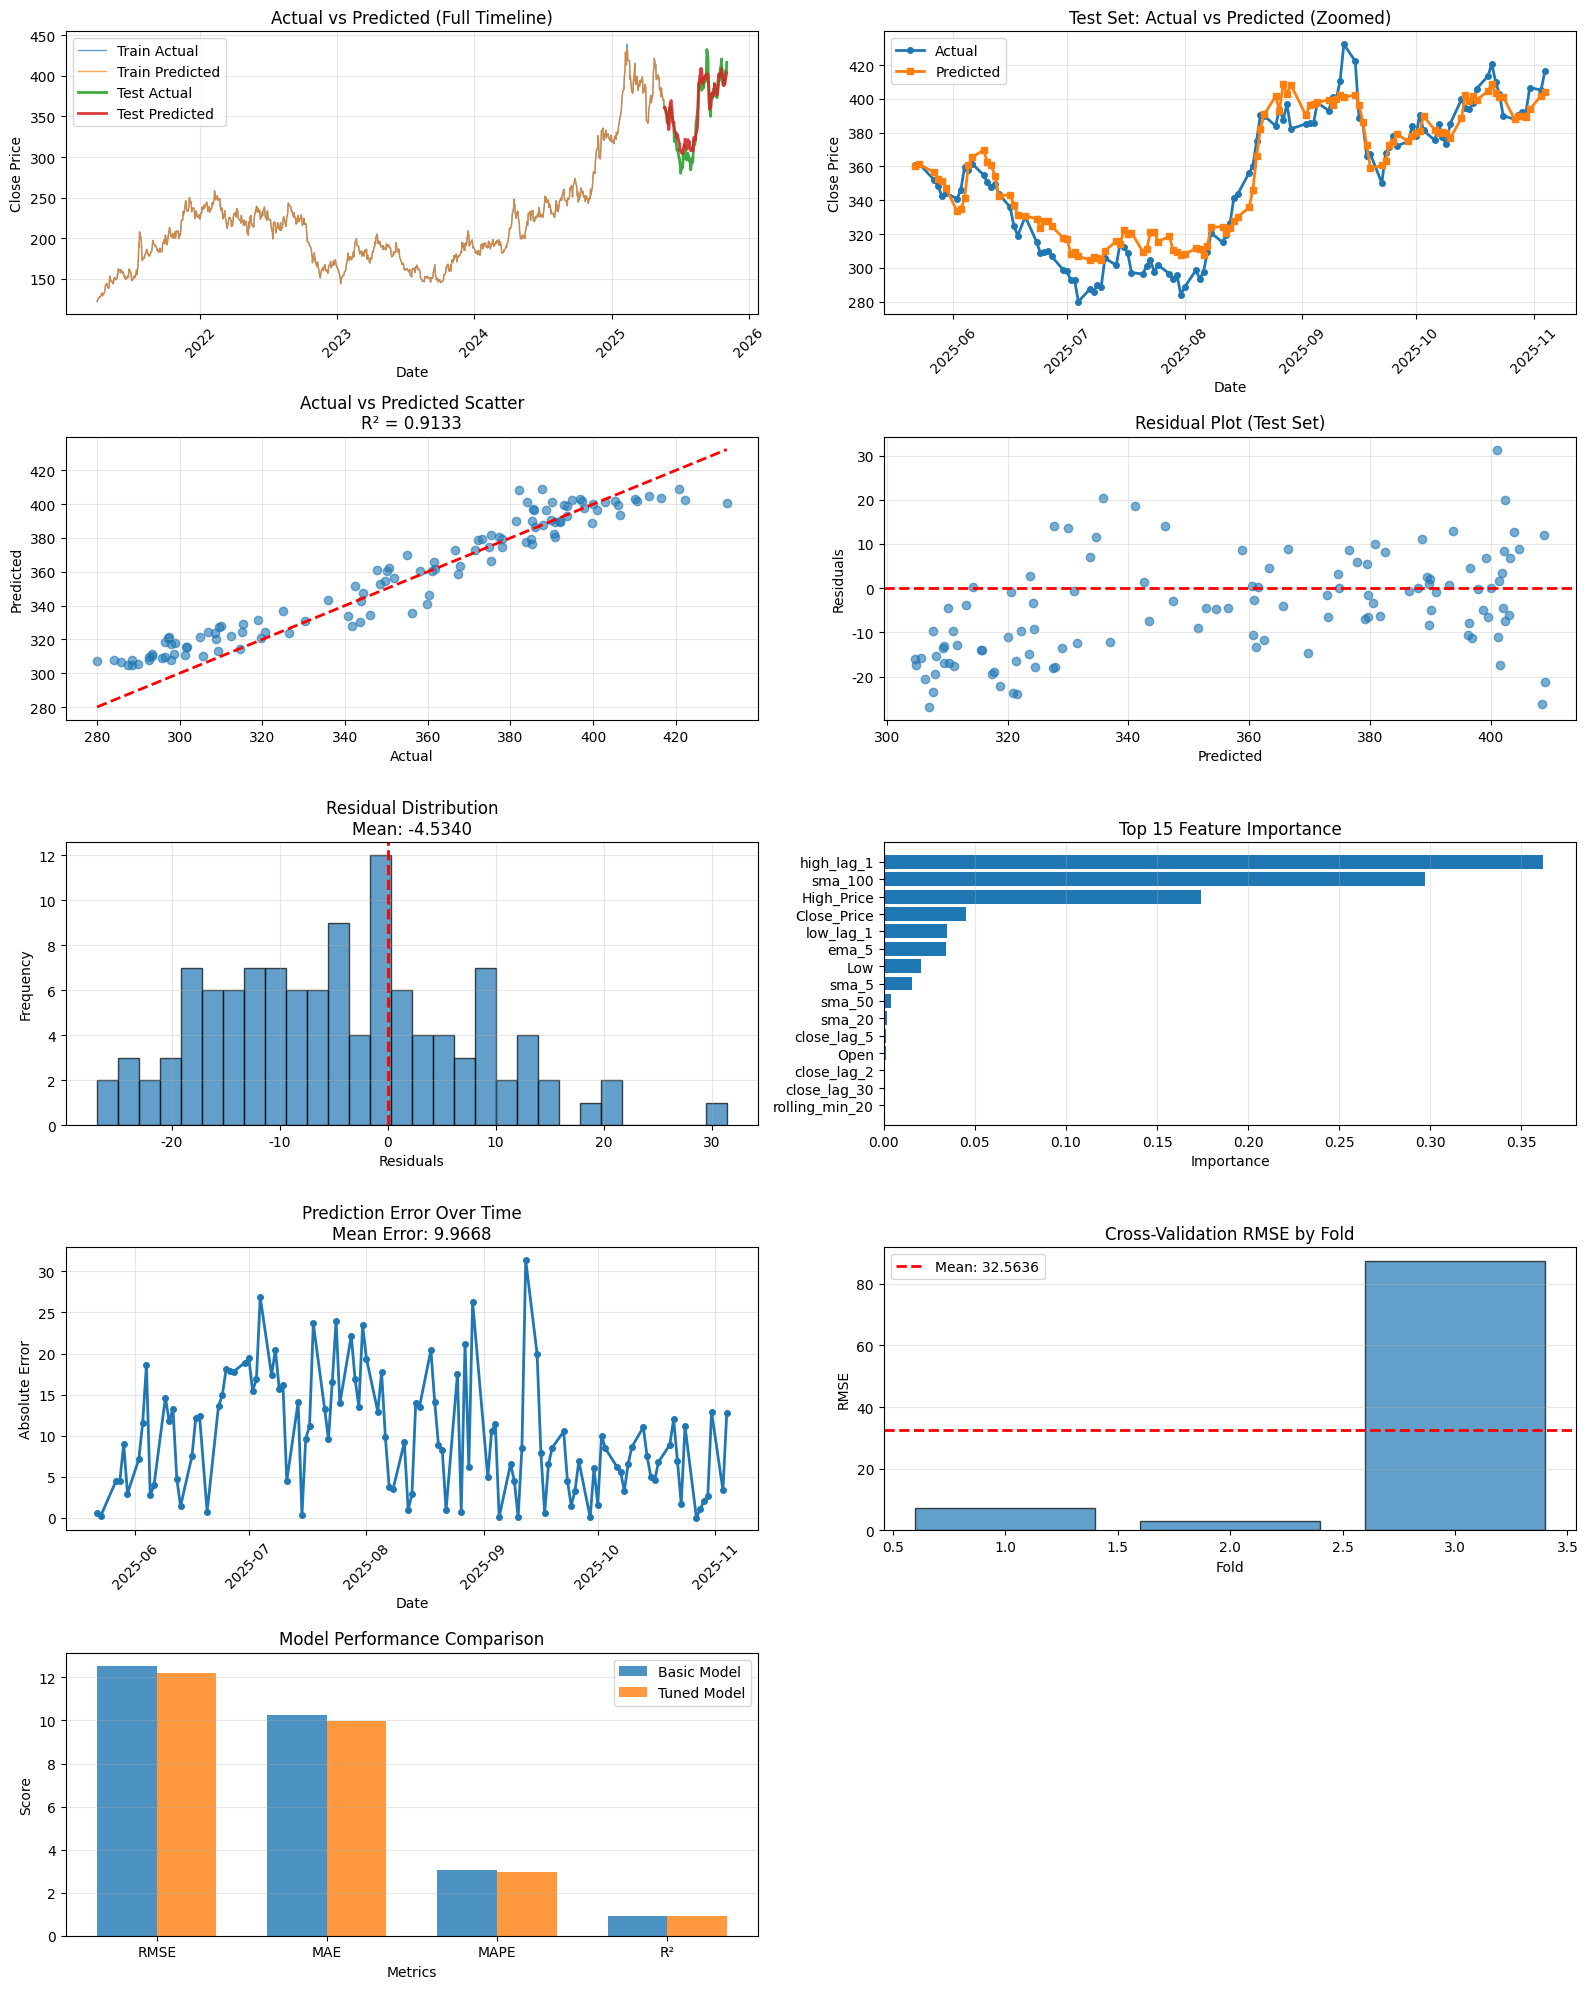

In [ ]:
"""
XGBoost 시계열 예측 모델
Close_Price 예측을 위한 전체 프로세스
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("XGBoost 시계열 예측 모델 학습 시작")
print("=" * 80)

# ============================================================================
# 1. 데이터 로드 및 기본 탐색
# ============================================================================
print("\n[1단계] 데이터 로드 및 기본 탐색")
print("-" * 80)

# 데이터 로드
#df_target = pd.read_csv('/content/coffee_features_clean.csv')

print(f"데이터 shape: {df_target.shape}")
print(f"\n결측치 개수:\n{df_target.isnull().sum().sum()} 개")
print(f"\n데이터 타입:\n{df_target.dtypes.value_counts()}")
#print(f"\n기본 통계량:")
#print(df[['Close_Price', 'High_Price', 'Low', 'Volume']].describe())

# ============================================================================
# 2. 시계열 특성 파악
# ============================================================================
print("\n[2단계] 시계열 특성 파악")
print("-" * 80)

# Date를 datetime으로 변환
df['Date'] = pd.to_datetime(df_target['Date'])
print(f"날짜 범위: {df_target['Date'].min()} ~ {df_target['Date'].max()}")
print(f"총 {len(df_target)}일 데이터")

# Target 변수 기본 통계
print(f"\nClose_Price 통계:")
print(f"  - 평균: {df_target['Close_Price'].mean():.2f}")
print(f"  - 표준편차: {df_target['Close_Price'].std():.2f}")
print(f"  - 최소값: {df_target['Close_Price'].min():.2f}")
print(f"  - 최대값: {df_target['Close_Price'].max():.2f}")

# ============================================================================
# 3. Feature 선택 및 전처리
# ============================================================================
print("\n[3단계] Feature 선택 및 전처리")
print("-" * 80)

# 제외할 컬럼 정의
columns_to_drop = ['Date', 'target_next_close']
print(f"제외할 컬럼: {columns_to_drop}")

# Feature와 Target 분리
#df_target = df.copy()
X = df_target.drop(columns_to_drop, axis=1)
y = df_target['target_next_close']

print(f"\nFeature 개수: {X.shape[1]}")
print(f"Target 개수: {len(y)}")
print(f"\nFeature 목록:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# 4. 데이터 분할 (시계열 순서 유지)
# ============================================================================
print("\n[4단계] 데이터 분할 (Train/Test)")
print("-" * 80)

# Train/Test 분할 (shuffle=False로 시계열 순서 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Train 기간: {df_target.iloc[y_train.index[0]]['Date']} ~ {df_target.iloc[y_train.index[-1]]['Date']}")
print(f"Test 기간: {df_target.iloc[y_test.index[0]]['Date']} ~ {df_target.iloc[y_test.index[-1]]['Date']}")

# ============================================================================
# 6. 모델 학습 (기본 모델)
# ============================================================================
print("\n[6단계] 기본 XGBoost 모델 학습")
print("-" * 80)

# 기본 XGBoost 모델
xgb_basic = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("모델 학습 중...")
xgb_basic.fit(X_train, y_train)
print("✓ 학습 완료!")

# ============================================================================
# 7. 예측 수행
# ============================================================================
print("\n[7단계] 예측 수행")
print("-" * 80)

# Train과 Test 예측
y_train_pred = xgb_basic.predict(X_train)
y_test_pred = xgb_basic.predict(X_test)

print("✓ 예측 완료!")

# ============================================================================
# 8. 모델 평가
# ============================================================================
print("\n[8단계] 모델 평가")
print("-" * 80)

def calculate_mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# Train 성능
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = calculate_mape(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test 성능
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = calculate_mape(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("📊 Train Set 성능:")
print(f"  - RMSE: {train_rmse:.4f}")
print(f"  - MAE: {train_mae:.4f}")
print(f"  - MAPE: {train_mape:.4f}%")
print(f"  - R² Score: {train_r2:.4f}")

print("\n📊 Test Set 성능:")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - MAPE: {test_mape:.4f}%")
print(f"  - R² Score: {test_r2:.4f}")

# ============================================================================
# 9. Feature Importance 분석
# ============================================================================
print("\n[9단계] Feature Importance 분석")
print("-" * 80)

# Feature Importance 계산
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_basic.feature_importances_
}).sort_values('importance', ascending=False)

print("\n상위 20개 중요 Feature:")
print(feature_importance.head(20).to_string(index=False))

# Feature Importance 저장
feature_importance.to_csv('/content/feature_importance_xgb.csv', index=False)
print("\n✓ Feature importance를 'feature_importance_xgb.csv'에 저장했습니다.")

# ============================================================================
# 10. 하이퍼파라미터 튜닝
# ============================================================================
print("\n[10단계] 하이퍼파라미터 튜닝 (RandomizedSearchCV)")
print("-" * 80)

# 파라미터 그리드 정의 (XGBoost에 맞게 수정)
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print("RandomizedSearchCV 실행 중... (시간이 걸릴 수 있습니다)")
print(f"파라미터 조합 수: 많은 조합 중 20개 랜덤 샘플링")

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_distributions,
    n_iter=20,  # 20개 조합만 테스트
    cv=TimeSeriesSplit(n_splits=3),  # 3-fold time series cross validation
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("\n✓ 튜닝 완료!")
print(f"\n최적 파라미터:")
for param, value in xgb_random.best_params_.items():
    print(f"  - {param}: {value}")

# 최적 모델로 예측
y_train_pred_tuned = xgb_random.predict(X_train)
y_test_pred_tuned = xgb_random.predict(X_test)

# 튜닝 후 성능
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
test_mape_tuned = calculate_mape(y_test, y_test_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

print("\n📊 튜닝 후 Test Set 성능:")
print(f"  - RMSE: {test_rmse_tuned:.4f} (개선: {test_rmse - test_rmse_tuned:.4f})")
print(f"  - MAE: {test_mae_tuned:.4f} (개선: {test_mae - test_mae_tuned:.4f})")
print(f"  - MAPE: {test_mape_tuned:.4f}% (개선: {test_mape - test_mape_tuned:.4f}%)")
print(f"  - R² Score: {test_r2_tuned:.4f} (개선: {test_r2_tuned - test_r2:.4f})")

# ============================================================================
# 11. 시계열 교차 검증
# ============================================================================
print("\n[11단계] 시계열 교차 검증 (TimeSeriesSplit)")
print("-" * 80)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []

print("3-Fold 시계열 교차 검증 수행 중...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 최적 모델로 학습
    cv_model = XGBRegressor(**xgb_random.best_params_, random_state=42, n_jobs=-1, verbosity=0)
    cv_model.fit(X_cv_train, y_cv_train)

    # 검증 세트 예측
    y_cv_pred = cv_model.predict(X_cv_val)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_scores.append(cv_rmse)

    print(f"  Fold {fold} - RMSE: {cv_rmse:.4f}")

print(f"\n평균 CV RMSE: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# ============================================================================
# 12. 결과 시각화
# ============================================================================
print("\n[12단계] 결과 시각화")
print("-" * 80)

# 그림 크기 설정
fig = plt.figure(figsize=(16, 20)) # Adjust figure size for 2 columns

# 1) 실제값 vs 예측값 비교 (Train + Test)
ax1 = plt.subplot(5, 2, 1) # 5 rows, 2 columns, position 1
dates_train = df_target.iloc[y_train.index]['Date']
dates_test = df_target.iloc[y_test.index]['Date']

plt.plot(dates_train, y_train.values, label='Train Actual', alpha=0.7, linewidth=1)
plt.plot(dates_train, y_train_pred_tuned, label='Train Predicted', alpha=0.7, linewidth=1)
plt.plot(dates_test, y_test.values, label='Test Actual', alpha=0.9, linewidth=2)
plt.plot(dates_test, y_test_pred_tuned, label='Test Predicted', alpha=0.9, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted (Full Timeline)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2) Test 구간만 확대
ax2 = plt.subplot(5, 2, 2) # 5 rows, 2 columns, position 2
plt.plot(dates_test, y_test.values, 'o-', label='Actual', linewidth=2, markersize=4)
plt.plot(dates_test, y_test_pred_tuned, 's-', label='Predicted', linewidth=2, markersize=4)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test Set: Actual vs Predicted (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3) Scatter Plot (Test Set)
ax3 = plt.subplot(5, 2, 3) # 5 rows, 2 columns, position 3
plt.scatter(y_test, y_test_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Scatter\nR² = {test_r2_tuned:.4f}')
plt.grid(True, alpha=0.3)

# 4) 잔차 분석 (Test Set)
ax4 = plt.subplot(5, 2, 4) # 5 rows, 2 columns, position 4
residuals = y_test - y_test_pred_tuned
plt.scatter(y_test_pred_tuned, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)

# 5) 잔차 분포
ax5 = plt.subplot(5, 2, 5) # 5 rows, 2 columns, position 5
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution\nMean: {residuals.mean():.4f}')
plt.grid(True, alpha=0.3)

# 6) Feature Importance (상위 15개)
ax6 = plt.subplot(5, 2, 6) # 5 rows, 2 columns, position 6
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# 7) 예측 오차 시계열 (Test Set)
ax7 = plt.subplot(5, 2, 7) # 5 rows, 2 columns, position 7
errors = np.abs(y_test - y_test_pred_tuned)
plt.plot(dates_test, errors, 'o-', linewidth=2, markersize=4)
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.title(f'Prediction Error Over Time\nMean Error: {errors.mean():.4f}')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8) 교차 검증 결과
ax8 = plt.subplot(5, 2, 8) # 5 rows, 2 columns, position 8
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, edgecolor='black')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cv_scores):.4f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE by Fold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 9) 성능 비교 (기본 모델 vs 튜닝 모델)
ax9 = plt.subplot(5, 2, 9) # 5 rows, 2 columns, position 9
metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
basic_scores = [test_rmse, test_mae, test_mape, test_r2]
tuned_scores = [test_rmse_tuned, test_mae_tuned, test_mape_tuned, test_r2_tuned]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, basic_scores, width, label='Basic Model', alpha=0.8)
plt.bar(x + width/2, tuned_scores, width, label='Tuned Model', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


# Add a placeholder for the 10th plot if needed, or adjust the layout
# ax10 = plt.subplot(5, 2, 10) # 5 rows, 2 columns, position 10
# plt.axis('off') # Turn off the axis for the empty plot

plt.tight_layout()
#plt.savefig('/content/xgb_model_results.png', dpi=300, bbox_inches='tight')
#print("✓ 시각화 결과를 'xgb_model_results.png'에 저장했습니다.")

# ============================================================================
# 13. 모델 저장
# ============================================================================
print("\n[13단계] 모델 저장")
print("-" * 80)

# 최적 모델 저장
#joblib.dump(xgb_random.best_estimator_, '/content/xgb_model_tuned.pkl')
#print("✓ 튜닝된 모델을 'xgb_model_tuned.pkl'에 저장했습니다.")

# 기본 모델도 저장
#joblib.dump(xgb_basic, '/content/xgb_model_basic.pkl')
#print("✓ 기본 모델을 'xgb_model_basic.pkl'에 저장했습니다.")

# ============================================================================
# 결과 요약 저장
# ============================================================================
print("\n[최종] 결과 요약 저장")
print("-" * 80)

summary = {
    'model': ['Basic XGBoost', 'Tuned XGBoost'],
    'test_rmse': [test_rmse, test_rmse_tuned],
    'test_mae': [test_mae, test_mae_tuned],
    'test_mape': [test_mape, test_mape_tuned],
    'test_r2': [test_r2, test_r2_tuned],
    'train_rmse': [train_rmse, np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))],
    'cv_mean_rmse': [None, np.mean(cv_scores)],
    'cv_std_rmse': [None, np.std(cv_scores)]
}

summary_df = pd.DataFrame(summary)
#summary_df.to_csv('/mnt/user-data/outputs/model_summary_xgb.csv', index=False)
#print("✓ 모델 성능 요약을 'model_summary_xgb.csv'에 저장했습니다.")

print("\n" + "=" * 80)
print("✅ 모든 프로세스 완료!")
print("=" * 80)
print("\n생성된 파일:")
print("  1. xgb_model_basic.pkl - 기본 XGBoost 모델")
print("  2. xgb_model_tuned.pkl - 튜닝된 XGBoost 모델")
print("  3. feature_importance_xgb.csv - Feature 중요도 순위")
print("  4. model_summary_xgb.csv - 모델 성능 요약")
print("  5. xgb_model_results.png - 결과 시각화 차트")
print("\n최종 Test Set 성능 (튜닝 모델):")
print(f"  - RMSE: {test_rmse_tuned:.4f}")
print(f"  - MAE: {test_mae_tuned:.4f}")
print(f"  - MAPE: {test_mape_tuned:.4f}%")
print(f"  - R² Score: {test_r2_tuned:.4f}")
print("=" * 80)